In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/DL\ Proj/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj


### Velocity

In [2]:
import numpy as np
import pandas as pd
from video_dataset import VideoDatasetWithFlows
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter1d
from sklearn.mixture import GaussianMixture
import sys
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def gaussian_video(video, lengths, sigma=3):
    scores = np.zeros_like(video)
    prev = 0
    for cur in lengths:
        scores[prev: cur] = gaussian_filter1d(video[prev: cur], sigma)
        prev = cur
    return scores

def macro_auc(video, test_labels, lengths):
    prev = 0
    auc = 0
    for i, cur in enumerate(lengths):
        cur_auc = roc_auc_score(np.concatenate(([0], test_labels[prev: cur], [1])),
                             np.concatenate(([0], video[prev: cur], [sys.float_info.max])))
        auc += cur_auc
        prev = cur
    return auc / len(lengths)

def dataload(root, thresh):
  if thresh == '26':
    train_velocity = np.load(root + '/train_ucsd_velocity.npy', allow_pickle=True)
    test_velocity = np.load(root + '/test_ucsd_velocity.npy', allow_pickle=True)
  else:
    train_velocity = np.load(root + '/train_velocity_'+thresh+'.npy', allow_pickle=True)
    test_velocity = np.load(root + '/test_velocity'+thresh+'.npy', allow_pickle=True)
  
  train_velocity = np.concatenate(train_velocity, 0)
  return train_velocity, test_velocity

In [4]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

def grid_search_method(train_velocity, params = 'kmeans'):
  param_grid = {
      "n_components": range(1, 7),
      "covariance_type": ["spherical", "tied", "diag", "full"],
  }
  grid_search = GridSearchCV(
      GaussianMixture(init_params = params, random_state=0), param_grid=param_grid, scoring=gmm_bic_score
  )
  grid_search.fit(train_velocity)

  df = pd.DataFrame(grid_search.cv_results_)[
      ["param_n_components", "param_covariance_type", "mean_test_score"]
  ]
  df["mean_test_score"] = -df["mean_test_score"]
  df = df.rename(
      columns={
          "param_n_components": "Number of components",
          "param_covariance_type": "Type of covariance",
          "mean_test_score": "BIC score",
      }
  )
  print(df.sort_values(by="BIC score").head())
  sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    )
  plt.show()

In [6]:
def evaluate(root, thresh, train_velocity, test_velocity, final = False, model = GaussianMixture(n_components=2, random_state=0)):

    test_clip_lengths = np.load(root + '/UCSD_Anomaly_Dataset.v1p2/UCSDped2/test_clip_lengths.npy', allow_pickle= True)

    test_dataset = VideoDatasetWithFlows(dataset_name='ped2', root=root+ "/UCSD_Anomaly_Dataset.v1p2/UCSDped2/",
                                         train=False, sequence_length=0, all_bboxes=None, normalize=False, mode='last')
    
    velocity_density_estimator = model.fit(train_velocity)
    
    train_velocity_scores = -velocity_density_estimator.score_samples(train_velocity)

    min_velocity = np.min(train_velocity_scores)
    max_velocity = np.percentile(train_velocity_scores, 99.9)

    test_velocity_scores = []
    
    for i in tqdm(range(len(test_dataset)), total=len(test_dataset)):
        cur_velocity = test_velocity[i]

        max_score_velocity = np.max(-velocity_density_estimator.score_samples(cur_velocity))
        test_velocity_scores.append(max_score_velocity)

    test_velocity_scores = np.array(test_velocity_scores)

    test_velocity_scores = (test_velocity_scores - min_velocity) / (max_velocity - min_velocity)
    
    if final:
      print(root+'/test_velocity_scores_'+thresh+'.npy')
      np.save(root+'/test_velocity_scores_'+thresh+'.npy',test_velocity_scores)

    final_scores = gaussian_video(test_velocity_scores, test_clip_lengths, sigma=3)

    print('Micro AUC: ', roc_auc_score(test_dataset.all_gt, final_scores) * 100)
    print('Macro AUC: ', macro_auc(final_scores, test_dataset.all_gt, test_clip_lengths) * 100)

### For 0.26 threshold

In [8]:
threshold = '26'

   Number of components Type of covariance    BIC score
2                     3          spherical  5161.901540
14                    3               diag  5161.901540
20                    3               full  5161.901540
5                     6          spherical  5506.843441
17                    6               diag  5506.843441


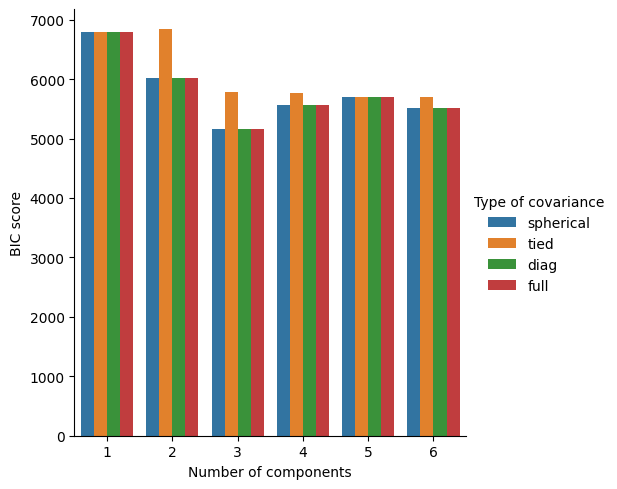

100%|██████████| 2010/2010 [00:00<00:00, 4513.87it/s]


/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/test_velocity_scores_26.npy
Micro AUC:  96.36307863541276
Macro AUC:  98.38506647870182


In [7]:
# Default with 0.26 and kmeans GaussianMixture(n_components=2, random_state=0)
x,y = dataload(os.getcwd(),threshold)
grid_search_method(x)
evaluate(os.getcwd(),threshold,x,y, final = True)

In [9]:
# with 0.26 and kmeans GaussianMixture(n_components=2, random_state=0) --- AUC decreases
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=3, random_state=0, covariance_type = 'spherical'))

100%|██████████| 2010/2010 [00:01<00:00, 1735.84it/s]

Micro AUC:  97.55823231239609
Macro AUC:  97.85417709887686


In [10]:
# # with 0.26 and kmeans GaussianMixture(n_components=2, random_state=0, covariance_type = 'diag') --- AUC decreases
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=3, random_state=0, covariance_type = 'diag'))

100%|██████████| 2010/2010 [00:00<00:00, 3422.36it/s]


Micro AUC:  97.55823231239609
Macro AUC:  97.85417709887686


   Number of components Type of covariance    BIC score
20                    3               full  5159.279061
2                     3          spherical  5159.279061
14                    3               diag  5159.279061
21                    4               full  5409.757475
3                     4          spherical  5409.757475


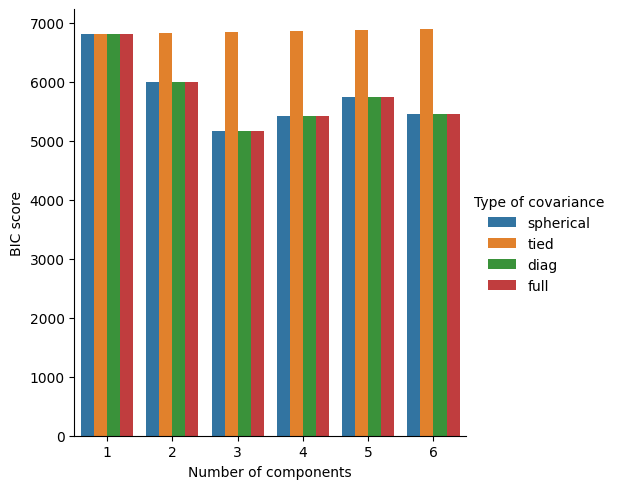

In [11]:
# Checking best config for kmeans++
grid_search_method(x, params = 'k-means++')

In [12]:
# No improvement
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=3, random_state=0, init_params = 'k-means++'))

100%|██████████| 2010/2010 [00:00<00:00, 4312.29it/s]

Micro AUC:  97.76122405192298
Macro AUC:  98.10450150808553


In [13]:
# No improvement
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=3, random_state=0, init_params = 'k-means++',covariance_type = 'diag'))

100%|██████████| 2010/2010 [00:00<00:00, 3403.44it/s]


Micro AUC:  97.76122405192298
Macro AUC:  98.10450150808553


In [14]:
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=2, random_state=0, init_params = 'k-means++',covariance_type = 'diag'))

100%|██████████| 2010/2010 [00:00<00:00, 5355.31it/s]


Micro AUC:  98.03277369522073
Macro AUC:  98.33905173646312


### For 0.30 threshold

In [15]:
threshold = '30'

   Number of components Type of covariance    BIC score
3                     4          spherical  4483.201395
15                    4               diag  4483.201395
21                    4               full  4483.201395
2                     3          spherical  4610.540868
14                    3               diag  4610.540868


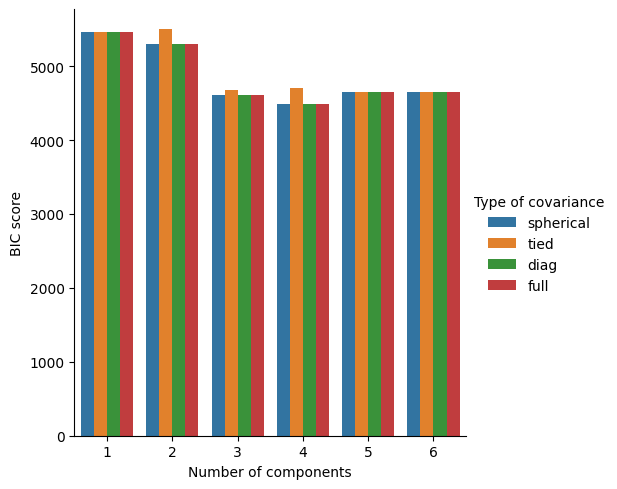

100%|██████████| 2010/2010 [00:00<00:00, 4757.10it/s]

Micro AUC:  95.1756356273132
Macro AUC:  98.0412864929882


In [16]:
# Default with 0.26 and kmeans GaussianMixture(n_components=2, random_state=0)
x,y = dataload(os.getcwd(),threshold)
grid_search_method(x)
evaluate(os.getcwd(),threshold,x,y)

In [17]:
# with 0.30 and kmeans GaussianMixture(n_components=3, random_state=0) --- micro AUC increases
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=4, random_state=0, covariance_type= 'spherical'))

100%|██████████| 2010/2010 [00:00<00:00, 2240.80it/s]


Micro AUC:  96.8376200182374
Macro AUC:  97.51418995443115


In [19]:
# Better
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=3, random_state=0, covariance_type = 'spherical'))

100%|██████████| 2010/2010 [00:00<00:00, 4011.92it/s]

Micro AUC:  96.23484685941102
Macro AUC:  98.187205208081


   Number of components Type of covariance    BIC score
23                    6               full  4564.507573
5                     6          spherical  4564.507573
17                    6               diag  4564.507573
2                     3          spherical  4628.291725
14                    3               diag  4628.291725


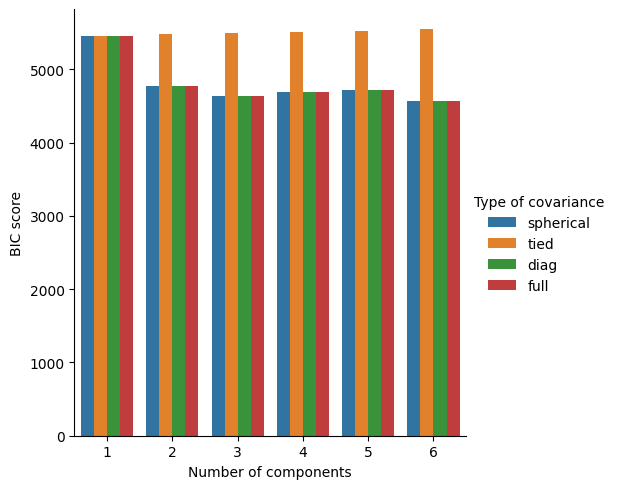

In [20]:
# Checking best config for kmeans++
grid_search_method(x, params = 'k-means++')

In [21]:
# No improvement
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=6, random_state=0, init_params = 'k-means++', covariance_type = 'spherical'))

100%|██████████| 2010/2010 [00:00<00:00, 4062.28it/s]


Micro AUC:  96.5682494770155
Macro AUC:  97.4265661325513


In [22]:
# No improvement
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=3, random_state=0, init_params = 'k-means++', covariance_type = 'spherical'))

100%|██████████| 2010/2010 [00:00<00:00, 2305.32it/s]

Micro AUC:  95.921559030199
Macro AUC:  98.14684546516985


In [25]:
# Better
evaluate(os.getcwd(),threshold,x,y, final = True, model = GaussianMixture(n_components=3, random_state=0, covariance_type = 'spherical'))

100%|██████████| 2010/2010 [00:01<00:00, 1455.77it/s]


/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/test_velocity_scores_30.npy
Micro AUC:  96.23484685941102
Macro AUC:  98.187205208081


### 0.36 Threshold

In [26]:
threshold = '36'

   Number of components Type of covariance    BIC score
3                     4          spherical  3448.735145
15                    4               diag  3448.735145
21                    4               full  3448.735145
22                    5               full  3460.087438
4                     5          spherical  3460.087438


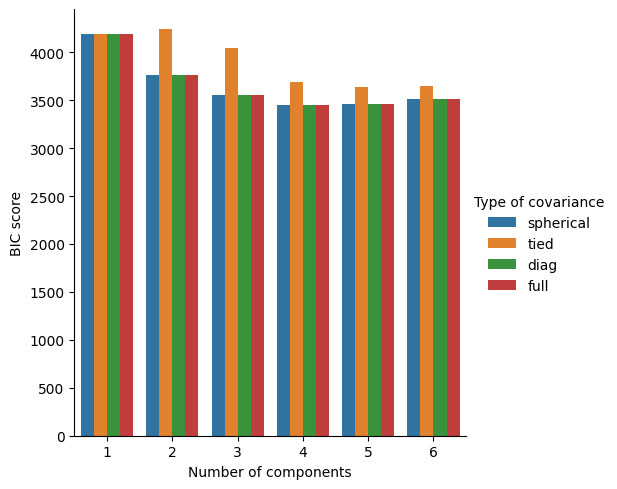

100%|██████████| 2010/2010 [00:00<00:00, 3043.12it/s]

Micro AUC:  93.67892774768009
Macro AUC:  97.36555272990527


In [27]:
# Default with 0.36 and kmeans GaussianMixture(n_components=2, random_state=0)
x,y = dataload(os.getcwd(),threshold)
grid_search_method(x)
evaluate(os.getcwd(),threshold,x,y)

In [28]:
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=4, random_state=0, covariance_type= 'spherical'))

100%|██████████| 2010/2010 [00:00<00:00, 3200.97it/s]


Micro AUC:  94.25069060773481
Macro AUC:  97.22364886086066


In [29]:
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=5, random_state=0, covariance_type= 'spherical'))

100%|██████████| 2010/2010 [00:01<00:00, 1407.41it/s]


Micro AUC:  95.10623960735933
Macro AUC:  96.89778934178406


   Number of components Type of covariance    BIC score
22                    5               full  3365.847666
16                    5               diag  3365.847666
4                     5          spherical  3365.847666
23                    6               full  3418.039358
5                     6          spherical  3418.039358


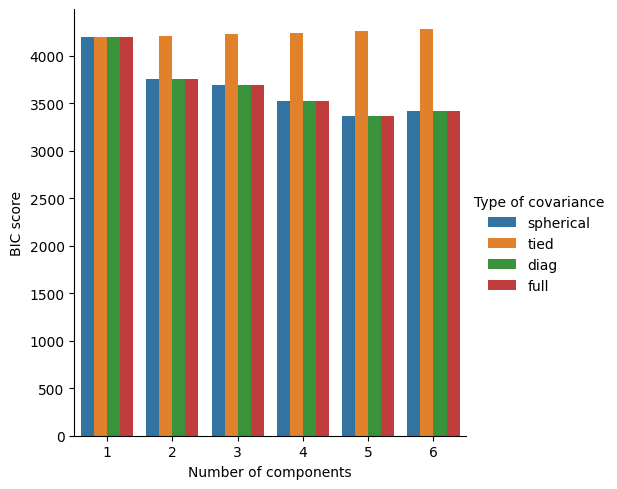

In [30]:
# Checking best config for kmeans++
grid_search_method(x, params = 'k-means++')

In [33]:
# Best
evaluate(os.getcwd(),threshold,x,y,final = True, model = GaussianMixture(n_components=5, random_state=0, init_params = 'k-means++', covariance_type = 'spherical'))

100%|██████████| 2010/2010 [00:00<00:00, 2126.52it/s]

/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/test_velocity_scores_36.npy
Micro AUC:  95.0718768438556
Macro AUC:  97.52552496229293


In [32]:
evaluate(os.getcwd(),threshold,x,y, model = GaussianMixture(n_components=6, random_state=0, init_params = 'k-means++', covariance_type = 'spherical'))

100%|██████████| 2010/2010 [00:00<00:00, 2240.11it/s]


Micro AUC:  94.90291262135922
Macro AUC:  97.48403869459906


### Code Layout

In [ ]:
import numpy as np
from video_dataset import VideoDatasetWithFlows
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter1d
from sklearn.mixture import GaussianMixture
import sys
from sklearn.model_selection import GridSearchCV

def gaussian_video(video, lengths, sigma=3):
    scores = np.zeros_like(video)
    prev = 0
    for cur in lengths:
        scores[prev: cur] = gaussian_filter1d(video[prev: cur], sigma)
        prev = cur
    return scores

def macro_auc(video, test_labels, lengths):
    prev = 0
    auc = 0
    for i, cur in enumerate(lengths):
        cur_auc = roc_auc_score(np.concatenate(([0], test_labels[prev: cur], [1])),
                             np.concatenate(([0], video[prev: cur], [sys.float_info.max])))
        auc += cur_auc
        prev = cur
    return auc / len(lengths)


root = os.getcwd()
train_velocity = np.load(root + '/train_ucsd_velocity.npy', allow_pickle=True)
train_velocity = np.concatenate(train_velocity, 0)

test_velocity = np.load(root + '/test_ucsd_velocity.npy', allow_pickle=True)
test_clip_lengths = np.load(root + '/UCSD_Anomaly_Dataset.v1p2/UCSDped2/test_clip_lengths.npy', allow_pickle= True)

test_dataset = VideoDatasetWithFlows(dataset_name='ped2', root=root+ "/UCSD_Anomaly_Dataset.v1p2/UCSDped2/",
                                      train=False, sequence_length=0, all_bboxes=None, normalize=False, mode='last')

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(init_params = 'k-means++'), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(train_velocity)


# velocity_density_estimator = GaussianMixture(n_components=2, random_state=0).fit(train_velocity)

# train_velocity_scores = -velocity_density_estimator.score_samples(train_velocity)
# print(train_velocity_scores.shape)

# min_velocity = np.min(train_velocity_scores)
# max_velocity = np.percentile(train_velocity_scores, 99.9)

# test_velocity_scores = []

# for i in tqdm(range(len(test_dataset)), total=len(test_dataset)):
#     cur_velocity = test_velocity[i]

#     max_score_velocity = np.max(-velocity_density_estimator.score_samples(cur_velocity))
#     test_velocity_scores.append(max_score_velocity)

# test_velocity_scores = np.array(test_velocity_scores)
# print(test_velocity_scores.shape)

# test_velocity_scores = (test_velocity_scores - min_velocity) / (max_velocity - min_velocity)

# final_scores = gaussian_video(test_velocity_scores, test_clip_lengths, sigma=2)
# print(final_scores.shape)

# print('Micro AUC: ', roc_auc_score(test_dataset.all_gt, final_scores) * 100)
# print('Macro AUC: ', macro_auc(final_scores, test_dataset.all_gt, test_clip_lengths) * 100)

GridSearchCV(estimator=GaussianMixture(init_params='k-means++'),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x7f622929db40>)

In [ ]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
14,3,diag,5171.154661
20,3,full,5172.929274
5,6,spherical,5301.846342
23,6,full,5397.866861
17,6,diag,5398.313788


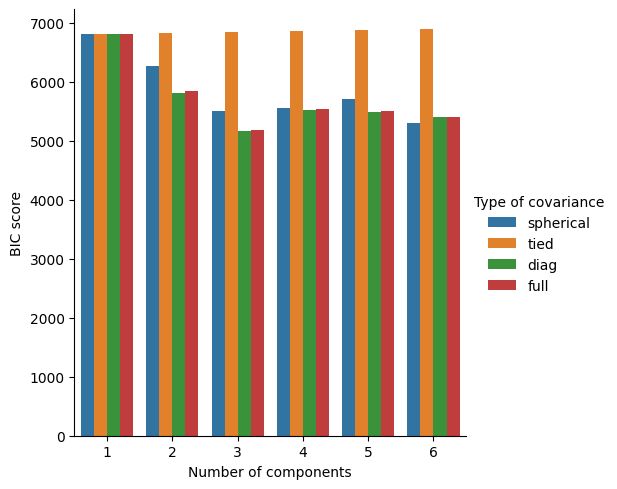

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



### Graphs

In [5]:
test_velocity_scores = np.load('/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj/test_velocity_scores_26.npy')

In [7]:
test_velocity_scores.shape

(2010,)

In [10]:
d = {'velocity_score': test_velocity_scores[180:360], 'Frame':np.arange(0,180)}
df = pd.DataFrame(d)

In [9]:
df

,velocity score,Frame
0,0.916231,0
1,0.675418,1
2,0.778550,2
3,0.518714,3
4,0.551893,4
...,...,...
175,3.547631,175
176,3.588342,176
177,3.868762,177
178,5.696976,178


In [11]:
import plotly.express as px

In [26]:
fig = px.line(df, x="Frame", y="velocity_score")
# fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]) )
fig.add_vrect(x0=95, x1=180, line_width=0, fillcolor="red", opacity=0.2,annotation_text="Ground Truth", annotation_position="bottom")
fig.update_xaxes(title = 'Frame Number')
fig.update_yaxes(title = 'Anomaly Score')
fig.update_layout(
    autosize=False,
    width=800,
    height=300,
    
    # legend_title="",
    # legend=dict(
    #     orientation="h",
    #     # entrywidth=70,
    #     yanchor="bottom",
    #     y=1,
    #     xanchor="right",
    #     x=0.87
    # )
)

In [ ]:
print(test_velocity_scores)

[0.91569799 0.69395042 0.4984449  ... 0.74515819 0.73427283 0.71293252]


In [ ]:
test_velocity_scores[178:182]

array([3.0985972 , 2.98180659, 0.91623119, 0.67541776])

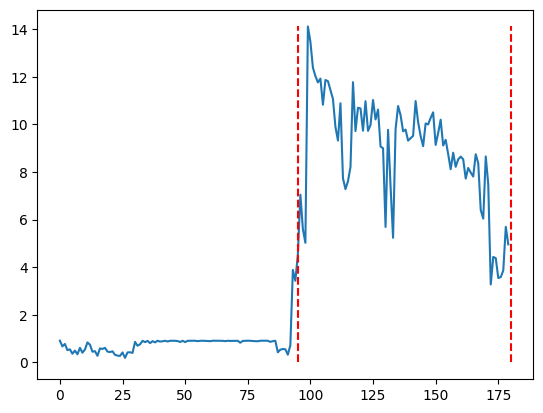

In [ ]:
import matplotlib.pyplot as plt

x_axis = np.arange(0,180)
y_axis = test_velocity_scores[180:360]

plt.plot(x_axis, y_axis)
plt.vlines(x = [95, 180], ymin=0, ymax=max(y_axis), color = 'r', ls='--')

In [ ]:
print(final_scores)

[0.7058748  0.66572686 0.60865055 ... 0.72549189 0.73109022 0.73186009]


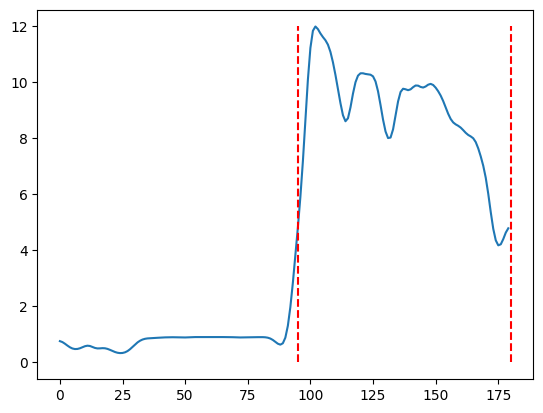

In [ ]:
import matplotlib.pyplot as plt

x_axis = np.arange(0,180)
y_axis = final_scores[180:360]

plt.plot(x_axis, y_axis)
plt.vlines(x = [95, 180], ymin=0, ymax=max(y_axis), color = 'r', ls='--')

### Inference

In [ ]:
%pwd

'/content/drive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj'

Inside Visual Flow


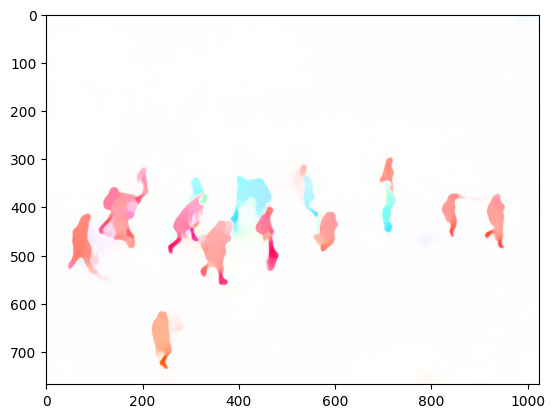

In [ ]:
from flownet2_pytorch.utils import flow_utils

org_file = '/content/drive/MyDrive/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/flows_imgs/Train001/048.tif.flo'

flow_utils.visulize_flow_file(org_file) #, '/content/drive/MyDrive/DL Proj/')

In [ ]:
from flownet2_pytorch.utils import flow_utils

org_file = '/content/drive/MyDrive/DL Proj/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/flows/Train001/049.tif.npy'

flow_utils.visulize_flow_file(org_file) #, '/content/drive/MyDrive/DL Proj/')

Inside Visual Flow
Magic number incorrect. Invalid .flo file


TypeError: ignored